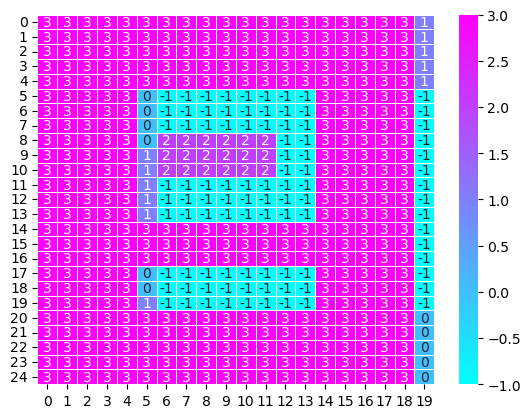

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

expert = np.load('expert_map.npy')

fig, ax = plt.subplots()
ax = sns.heatmap(expert, annot=True, fmt=".2g", cmap='cool', linewidths=.5)
plt.show()


Create your own expert map

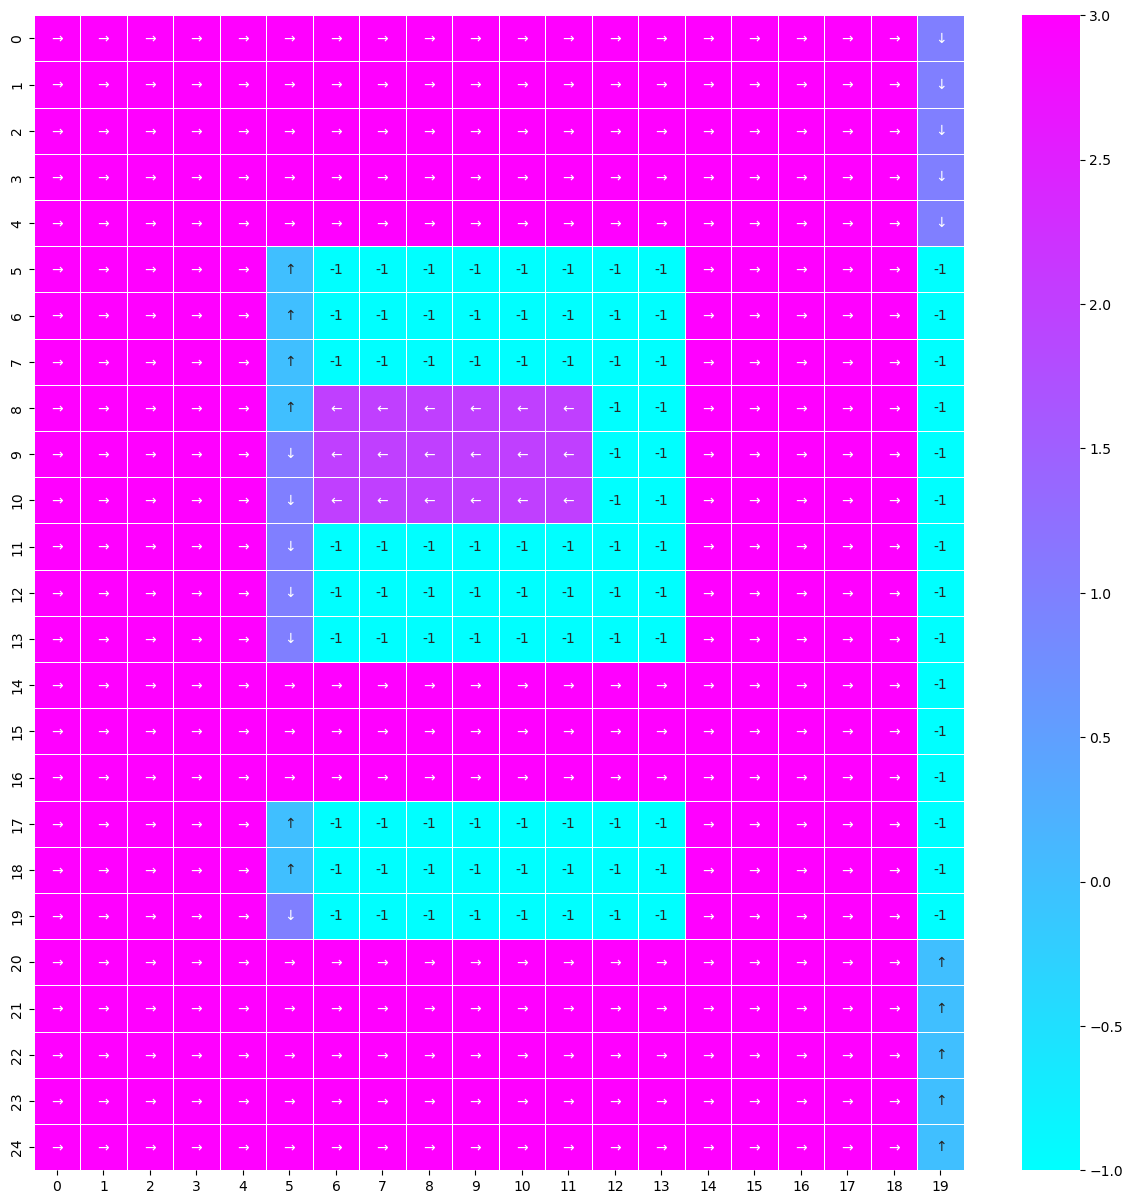

⮉


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

grid = np.full((25,20), 3)

grid[5:14, 6:14] = -1
grid[8:11, 6:12] = 2
grid[17:20, 6:14] = -1
grid[5:20, 19] = -1

grid[5:9, 5] = 0
grid[9:14, 5] = 1
grid[:5, 19] = 1
grid[20:, 19] = 0
grid[17:19, 5] = 0
grid[19,5] = 1

num_to_arrow = {0: u'\u2191', 1: u'\u2193', 2: u'\u2190', 3: u'\u2192', -1:'-1'}
f = np.vectorize(lambda x: num_to_arrow[x])
arrows = f(grid)

fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(grid, annot=arrows, fmt="s", cmap='cool', linewidths=.5)
plt.show()

np.save('expert_map.npy', grid)

print(u'\u2B89')

In [1]:
from neural_model import NeuralNet
import torch
import torch.nn as nn
import torch.functional as F

s = [torch.randn((128, 1, 5, 5)), torch.rand((128, 2))]
net = NeuralNet()
out = net(s)

c:\Users\siddh\anaconda3\envs\deeprobot\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([128, 12])
torch.Size([128, 8])


[ 10  20  30  40  50  60  70  80  90 100 102]
[5.2, 3.3, 3.2, 3.6, 4.0, 3.7, 4.0, 4.3, 4.6, 4.2, 5.5]


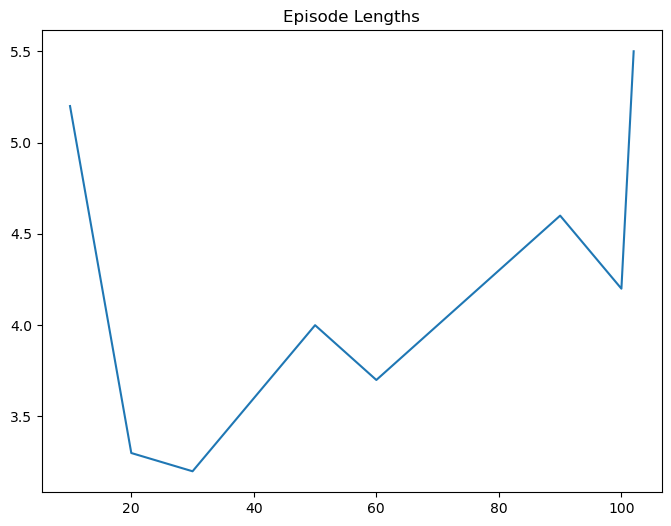

In [1]:
import numpy as np
import matplotlib.pyplot as plt

ep_lenghts = np.random.randint(0, 10, size=103)
smoothing_number = 10

x = np.arange(0, len(ep_lenghts), smoothing_number)
x = np.append(x, len(ep_lenghts)-1)
y = [np.average(ep_lenghts[x[i]:x[i+1]]) for i in range(len(x)-1)]
x = x[1:]
print(x)
print(y)

fig, ax0 = plt.subplots(figsize=(8,6))
ax0.set_title('Episode Lengths')
ax0.plot(x, y)
plt.show()

Meshgrid

In [14]:
import numpy as np

m = np.mgrid[0:15, 0:20]
# print(m.shape)

inds = np.stack((m[0], m[1]), axis=2)

# starts = list(inds[:, 4:6]) + list(inds[:, 14:16])
starts = inds[:, 14:16]
# print(starts)

inds = [[i, j] for i in range(15) for j in [14,15]]
print(inds)

[[0, 14], [0, 15], [1, 14], [1, 15], [2, 14], [2, 15], [3, 14], [3, 15], [4, 14], [4, 15], [5, 14], [5, 15], [6, 14], [6, 15], [7, 14], [7, 15], [8, 14], [8, 15], [9, 14], [9, 15], [10, 14], [10, 15], [11, 14], [11, 15], [12, 14], [12, 15], [13, 14], [13, 15], [14, 14], [14, 15]]


Evaluate models

In [33]:
import torch
import numpy as np
import os
from sparse_env import Grid
from dqn import DQN_Agent, QNet, MNet, VNet

env = Grid(patch_size=5, expert_map_f='expert_map.npy')
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


Q = QNet(device, 1e-4, '15k/v5/')
Q.load_model('15k/v5/models/Qmodel.pth')
M = MNet(device, 1e-4, '15k/v5/')
M.load_model('15k/v5/models/Mmodel.pth')
V = VNet(device, 1e-4, '15k/v5/')
V.load_model('15k/v5/models/Vmodel.pth')

Q.model.eval()
M.model.eval()
V.model.eval()

rows, cols = np.indices((15,13))
rows = rows.reshape(-1)
cols = cols.reshape(-1)
posns = np.stack((rows, cols), axis=1)

# Will give a list of 210 elements, each having the patch and posn of all cells in the grid
all_states = list(map(lambda x: env.yx_to_obs(x), posns))

# Will convert all patches and posns into one tensor each to be passed to the models
all_patches, all_posns = map(lambda x: torch.from_numpy(np.stack(x)).to(device), \
                            zip(*all_states))

# [Tensor_of_shape(210, 4, 3, 3), Tensor_of_shape(210, 2)]
all_state_tensors = [all_patches.float(), all_posns.float()]

# Q values and best actions
qvalues = Q.model(all_state_tensors)
best_actions = torch.argmax(qvalues, axis=1).reshape(-1)

# Plotting Best actions
best_actions_map = np.zeros((15,13))
best_actions_map[rows, cols] = best_actions.cpu().numpy()

# These states either have obstacles, traps or goals and their best action values
# do not make any sense. Will be set to -1 to avoid confusion
obstacle_x, obstacle_y = np.where(env.grid!=0)
best_actions_map[obstacle_x, obstacle_y] = -1

# Plotting Variances of every state
variances = V.model(all_state_tensors)
mvalues = M.model(all_state_tensors)


qvalues = qvalues.reshape(15,13,4)
mvalues = mvalues.reshape(15,13,4)
variances = variances.reshape(15,13,4)




print(qvalues[5,6])
print(mvalues[5,6])
print(variances[5,6])







tensor([-2.8319, -3.3365, -2.5845, -4.5445], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([1.4274, 0.5258, 2.0245, 2.4394], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.8763, -0.9781, -0.6084, -1.5651], device='cuda:0',
       grad_fn=<SelectBackward0>)


Using check_model_values to print the Q, M, V values at a particular grid cell

In [2]:
from dqn import DQN_Agent
from sparse_env import Grid
import torch
import os
os.chdir('/home/sidd/Human-in-the-loop-RL/')
print(os.getcwd())

print(os.path.isdir('DQN_sparse_map/Ocean/20k/v2/alg1/models'))

env = Grid(patch_size=5, expert_penalty=-5)
test_env = Grid(0, patch_size=5)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
lr = 1e-4			# Learning rate for Q, M models

DQN = DQN_Agent(env, test_env, lr, device)
DQN.check_model_values('DQN_sparse_map/Ocean/20k/v7/alg1/models', [3,10], alg2=False)
DQN.check_model_values('DQN_sparse_map/Ocean/20k/v8/alg1/models', [3,10], alg2=False)


/home/sidd/Human-in-the-loop-RL
True
DQN Initialized
m, and n are:  11 16
shape of all_state_tensors:  torch.Size([176, 1, 5, 5]) torch.Size([176, 2])
Q Values: tensor([-10.1215,  -9.5636,  -7.8181,  -5.6934, -12.5862], device='cuda:0',
       grad_fn=<SelectBackward0>)
m, and n are:  11 16
shape of all_state_tensors:  torch.Size([176, 1, 5, 5]) torch.Size([176, 2])
Q Values: tensor([-10.1215,  -9.5636,  -7.8181,  -5.6934, -12.5862], device='cuda:0',
       grad_fn=<SelectBackward0>)


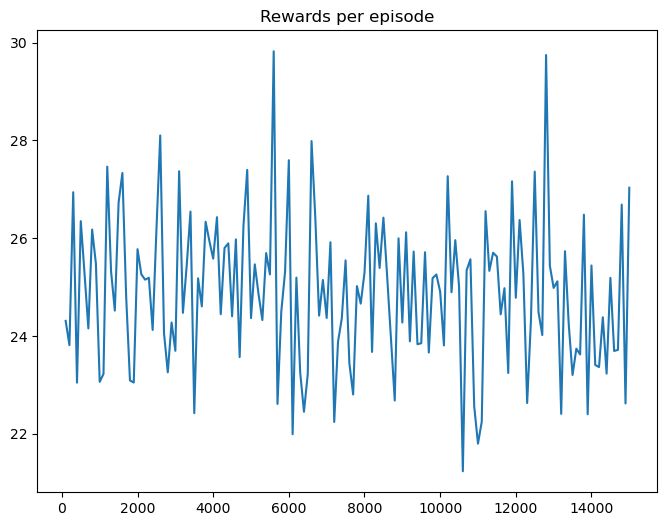

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizations
# Plotting Rewards
ep_rewards = np.random.uniform(0, 50, size=15000)

smoothing_number = 100
x = np.arange(0, len(ep_rewards), smoothing_number)
x = np.append(x, len(ep_rewards))
y = [np.average(ep_rewards[x[i]:x[i+1]]) for i in range(len(x)-1)]
x = x[1:]

fig, ax0 = plt.subplots(figsize=(8,6))
ax0.set_title('Rewards per episode')
ax0.plot(x, y)
# plt.savefig(os.path.join(self.logdir, 'Plots', 'rewards.jpg'), \
#     bbox_inches ="tight",\
#     dpi=250)
plt.show()

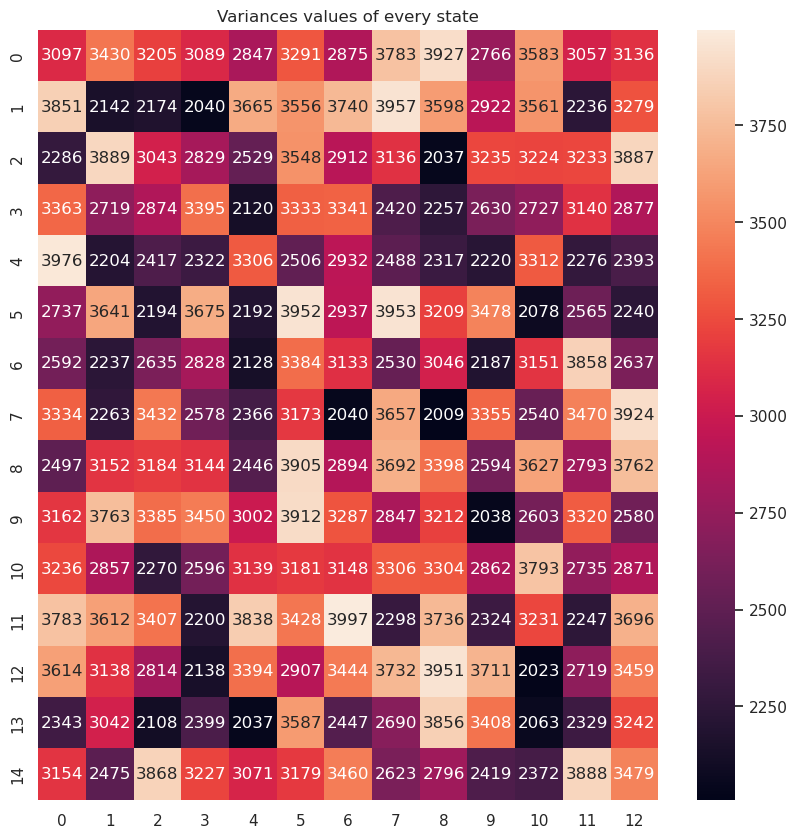

In [2]:
import numpy as np; np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()



fig, ax = plt.subplots(figsize=(10,10))
sns.set_palette("mako", 10)
uniform_data = np.random.uniform(2000.0, 4000.0, size=(15,13)).astype(int)
ax.set_title('Variances values of every state')
ax = sns.heatmap(uniform_data,annot=True, fmt=".0f")
plt.savefig('delete_plot.jpg')

Print out weights in a particular layer

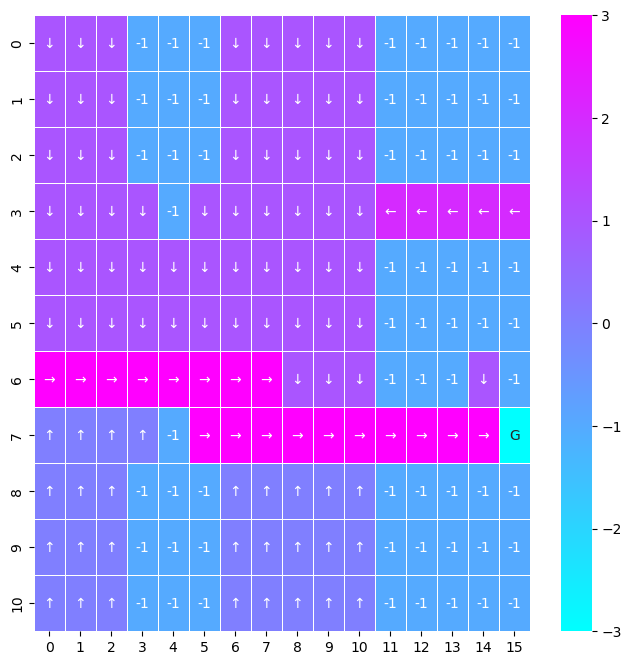

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

grid = np.zeros((11,16))
# Obstacle
grid[0:3, 3:6] = -1
grid[8:11, 3:6] = -1
grid[3, 4] = -1
grid[7, 4] = -1
grid[0:3, 11:16] = -1
grid[4:7, 11:16] = -1
grid[8:11, 11:16] = -1
grid[6, 14] = 0

# Goal
grid[7, 15] = -3

# Setting expert policy
grid[0:7, 6:11] = 1
grid[6, 14] = 1
grid[3, 3] = 1
grid[0:6, 0:3] = 1
grid[3, 5] = 1
grid[4:6, 3:6] = 1
grid[3, 11:16] = 2
grid[6, 0:8] = 3
grid[7, 5:15] = 3


num_to_arrow = {0: u'\u2191', 1: u'\u2193', 2: u'\u2190', 3: u'\u2192', -1:'-1', -3:'G'}
f = np.vectorize(lambda x: num_to_arrow[x])
arrows = f(grid)

np.save('Ocean/expert_policy.npy', grid.astype(int))

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(grid, annot=arrows, fmt="s", cmap='cool', linewidths=.5)
plt.show()



Extracting action plots from QValues.npy files

In [8]:
import os
import torch
import numpy as np
from sparse_env import Grid
from dqn import DQN_Agent
os.chdir('/home/sidd/Human-in-the-loop-RL/')
os.makedirs('DQN_sparse_map/Ocean/30k2/best_actions_4000', exist_ok=True)

for i in range(1, 10):
    qvalue_arr = np.load(f'DQN_sparse_map/Ocean/30k2/v{i}/alg1/Qvalues/Qvalues_4000.npy')
    # obstacle_x, obstacle_y = np.where(qvalue_arr==[-100, -100, -100, -100])
    best_actions = np.argmax(qvalue_arr, axis=2)
    # print(best_actions.shape)
    np.save(f'DQN_sparse_map/Ocean/30k2/best_actions_4000/best_actions_{i}_4000.npy', best_actions)



Plotting the best action plot at a particular episode number

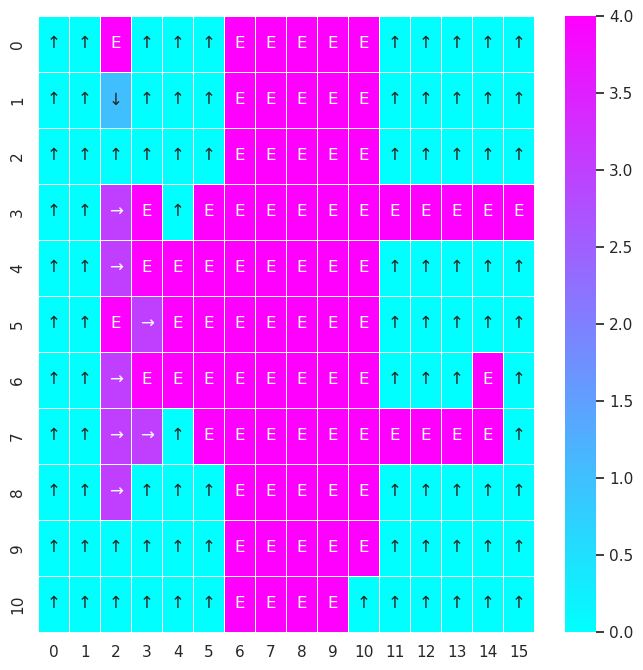

[17.9733963  16.18188667 14.4416256  21.39247704 22.94006348]


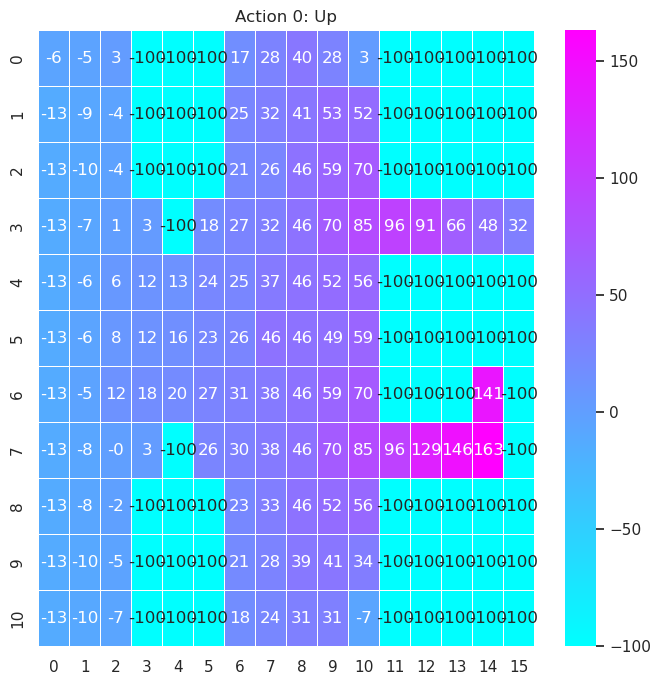

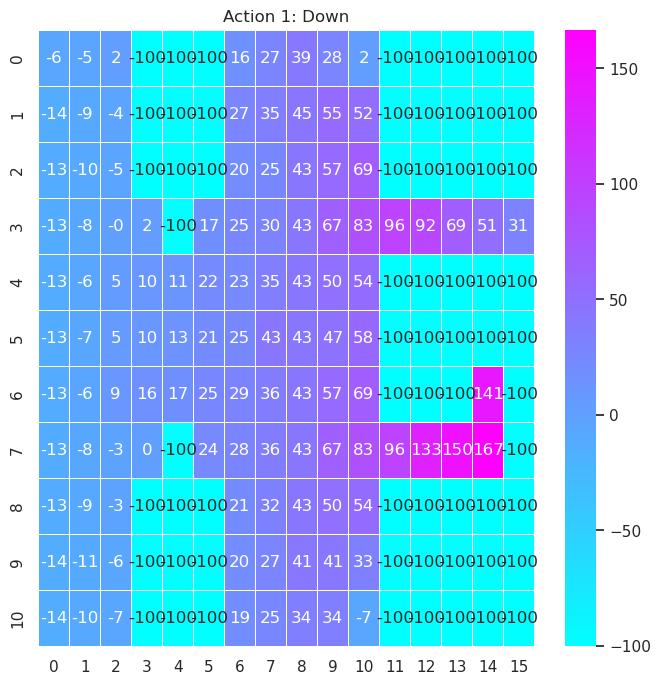

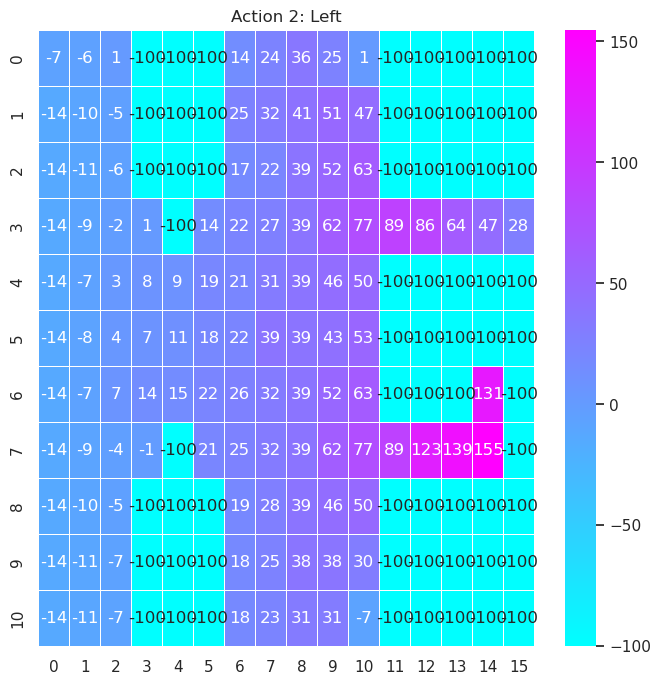

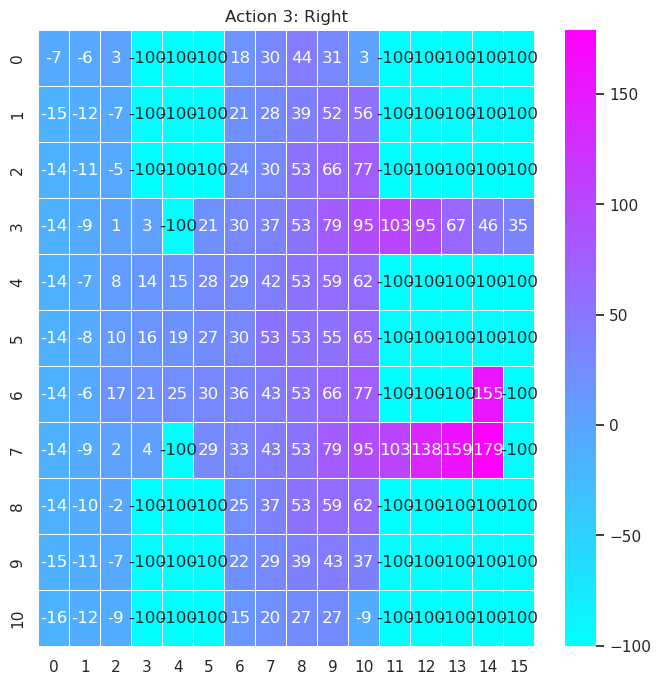

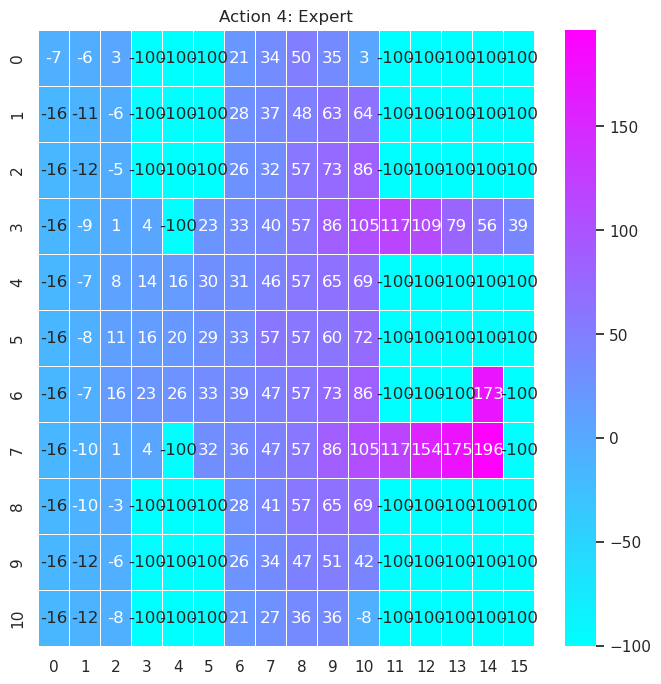

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/sidd/Human-in-the-loop-RL/')

sns.set_theme(style="whitegrid")
qvals = np.load('DQN_sparse_map/Ocean/10k5/algo1/v18/Qvalues/Qvalues_3000.npy')
grid = np.argmax(qvals, axis=2)

num_to_arrow = {0: u'\u2191', 1: u'\u2193', 2: u'\u2190', 3: u'\u2192', -1:'-1', -3:'G', 4:'E'}
f = np.vectorize(lambda x: num_to_arrow[x])
arrows = f(grid)

# Plot arrows on a heatmap
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(grid, annot=arrows, fmt="s", cmap='cool', linewidths=.5)
plt.show()

print(qvals[6, 3])

action_dict = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right', 4: 'Expert'}
# Plot all action q values
for i in range(5):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(f'Action {i}: {action_dict[i]}')
    ax = sns.heatmap(qvals[:, :, i], annot=True, fmt=".0f", cmap='cool', linewidths=.5)
    plt.show()


Running algo1 policy rollout at a specific action policy

In [2]:
import os
import torch
from sparse_env import Grid
from dqn import DQN_Agent
os.chdir('/home/sidd/Human-in-the-loop-RL/')


lr = 5e-5			# Learning rate for Q, M models
alg2 = False
logdir = 'DQN_sparse_map/Ocean/30k/v9/alg1'
expert_penalty = -0.9	# Value should be negative
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_num_threads(4)

# Adding all hyperparametres to a text file
os.makedirs(logdir, exist_ok=True)

env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
test_env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
DQN = DQN_Agent(env, test_env, lr, device, burn_in=2)


expert_calls_list = []
avg_return_list = []
for i in range(1, 10):
    expert_calls, avg_return, _ = \
        DQN.policy_rollout(2000, max_steps=25, qtable_f=f'DQN_sparse_map/Ocean/10k2/v6/Qvalues/Qvalues_3150.npy')
    expert_calls_list.append(expert_calls)
    avg_return_list.append(avg_return)
    
print('Expert calls:', expert_calls_list)
print('Average return:', avg_return_list)

DQN Initialized
Expert calls: [3.013, 2.9305, 2.9675, 2.949, 2.895, 2.95, 2.9765, 3.0235, 3.008]
Average return: [132.011, 134.091, 131.504, 133.533, 128.243, 128.81, 133.284, 132.419, 132.241]


Running algo1 monte carlo estimates on all expert penalties over all saved values to find iteration at which we achieve best action policy

In [12]:
import os
import torch
from sparse_env import Grid
import numpy as np
from dqn import DQN_Agent
import pickle
os.chdir('/home/sidd/Human-in-the-loop-RL/')


lr = 5e-5			# Learning rate for Q, M models
alg2 = False
logdir = 'DQN_sparse_map/Ocean/30k/v9/alg1'
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_num_threads(4)

# Adding all hyperparametres to a text file
os.makedirs(logdir, exist_ok=True)

env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
test_env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
DQN = DQN_Agent(env, test_env, lr, device, burn_in=2)
best_returns = {'versions': [], 'returns': [], 'expert_calls': [], 'episode_num': []}


for ver in range(0, 16):

    expert_calls_list = []
    avg_returns = []
    episode_num = []
    for ep in range(1000, 10000, 50):
        expert_calls, avg_return, _ = \
        DQN.policy_rollout(2000, max_steps=30, qtable_f=f'DQN_sparse_map/Ocean/10k5/algo1/v{ver}/Qvalues/Qvalues_{ep}.npy')
        avg_returns.append(avg_return)
        expert_calls_list.append(expert_calls)
        episode_num.append(ep)

    # print('Expert Calls: ', expert_calls_list)
    # print('Avg Returns: ', avg_returns)
    # print('Episode Num: ', episode_num)

    highest_return_ind = np.argmax(avg_returns)
    exp_highest_return = expert_calls_list[highest_return_ind]
    episode_high_return = episode_num[highest_return_ind]
    highest_return = avg_returns[highest_return_ind]
    print(f'For version {ver}, highest return is {highest_return} at episode {episode_high_return} with {exp_highest_return} expert calls')

    best_returns['versions'].append(ver)
    best_returns['returns'].append(highest_return)
    best_returns['expert_calls'].append(exp_highest_return)
    best_returns['episode_num'].append(episode_high_return)

# Save the dictionary
with open(f'DQN_sparse_map/Ocean/10k5/algo1/best_returns_algo1.pkl', 'wb') as f:
    pickle.dump(best_returns, f)


DQN Initialized
For version 1, highest return is 136.155 at episode 4450 with 2.9195 expert calls
For version 2, highest return is 135.596 at episode 4550 with 2.8445 expert calls
For version 3, highest return is 136.228 at episode 3450 with 3.358 expert calls
For version 4, highest return is 138.143 at episode 4550 with 3.341 expert calls
For version 5, highest return is 134.834 at episode 4950 with 2.8105 expert calls
For version 6, highest return is 133.308 at episode 3150 with 2.9275 expert calls
For version 7, highest return is 135.925 at episode 3050 with 3.5305 expert calls
For version 8, highest return is 121.1065 at episode 4850 with 1.4585 expert calls
For version 9, highest return is 123.332 at episode 3000 with 2.8695 expert calls
For version 10, highest return is 118.876 at episode 4000 with 2.118 expert calls


Loading expert calls, and episode number from best_returns_algo1.pkl

In [3]:
# Load dictionary using pickle
import pickle
import os
os.chdir('/home/sidd/Human-in-the-loop-RL/')

with open('DQN_sparse_map/Ocean/10k5/algo1/best_returns_algo1.pkl', 'rb') as f:
    best_returns = pickle.load(f)

print('version: ', best_returns['versions'])
print('returns: ', best_returns['returns'])
print('expert calls: ', best_returns['expert_calls'])
print('episode num: ', best_returns['episode_num'])



version:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
returns:  [175.572, 175.631, 175.465, 175.499, 175.318, 175.354, 175.478, 175.25, 175.404, 175.522, 157.662, 175.4, 156.308, 173.972, 175.352, 175.251, 161.9805, 144.467, 147.564, 132.8485, 126.816, 138.892, 133.7615]
expert calls:  [10.233, 12.017, 9.0365, 11.2195, 12.1035, 8.5435, 10.2165, 10.3715, 10.1795, 8.9915, 8.6175, 12.017, 6.7805, 8.1755, 11.9275, 9.307, 7.278, 7.8085, 9.3385, 2.33, 4.196, 7.872, 1.436]
episode num:  [8950, 5600, 9550, 8550, 9100, 5500, 9550, 4600, 4250, 3000, 4750, 5450, 5200, 5400, 2500, 8250, 2900, 1250, 2450, 3800, 6100, 1600, 2950]


Running algo1 monte carlo estimates across different expert penalty versions

In [9]:
import os
import torch
from sparse_env import Grid
from dqn import DQN_Agent
os.chdir('/home/sidd/Human-in-the-loop-RL/')


lr = 5e-5			# Learning rate for Q, M models
alg2 = False
logdir = 'DQN_sparse_map/Ocean/30k/v9/alg1'
expert_penalty = -0.9	# Value should be negative
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_num_threads(4)

# Adding all hyperparametres to a text file
os.makedirs(logdir, exist_ok=True)

env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
test_env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
DQN = DQN_Agent(env, test_env, lr, device, burn_in=2)
expert_calls_list = []
avg_returns = []

# Policy Rollout on Vanilla DQN
# exp, ret, stuck = DQN.policy_rollout(1000, max_steps=25, best_action_f=f'DQN_sparse_map/Ocean/10k/v1/Plots/Best_actions.npy')
# print('Expert calls: ', exp)
# print('Average Returns: ', ret)
# print('Stuck: ', stuck)

# Policy rollout on best actions policies saved from algo1 
for i in range(1, 10):
    expert_calls, avg_return, _ = \
    DQN.policy_rollout(1000, max_steps=25, best_action_f=f'DQN_sparse_map/Ocean/30k2/best_actions_4000/best_actions_{i}_4000.npy')
    avg_returns.append(avg_return)
    expert_calls_list.append(expert_calls)

print('Expert calls: ', expert_calls_list)
print('Average Returns: ', avg_returns)


DQN Initialized
Expert calls:  [2.708, 2.271, 3.931, 2.943, 3.509, 1.8, 2.12, 1.501, 1.761]
Average Returns:  [50.489, 82.306, 119.052, 96.66, 86.431, 82.28, 93.818, 90.412, 90.076]


Monte Carlo Estimates by thresholding the variance values from algo2

In [9]:
import os
import torch
from sparse_env import Grid
from dqn import DQN_Agent
os.chdir('/home/sidd/Human-in-the-loop-RL/')


lr = 5e-5			# Learning rate for Q, M models
alg2 = False
logdir = 'DQN_sparse_map/Ocean/30k/v9/alg1'
expert_penalty = 0	# Value should be negative
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_num_threads(4)

# Adding all hyperparametres to a text file
os.makedirs(logdir, exist_ok=True)

env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
test_env = Grid(0, patch_size=5)
DQN = DQN_Agent(env, test_env, lr, device, burn_in=2)
DQN.threshold_rollout(1000, thresh_spacing=20, dir_f='DQN_sparse_map/Ocean/10k/v1/Plots/', max_steps=25)

DQN Initialized
Thresholds:  [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020]
Average number of expert calls made:  [12.613, 11.549, 11.363, 11.402, 11.587, 11.652, 11.58, 11.415, 10.535, 10.391, 10.585, 10.284, 10.227, 10.21, 10.399, 10.057, 8.605, 8.383, 9.211, 8.872, 8.706, 8.616, 8.141, 7.924, 7.581, 7.539, 7.562, 7.53, 7.433, 7.732, 7.309, 7.131, 7.163, 7.253, 6.887, 6.882, 6.931, 6.942, 6.597, 6.329, 6.408, 6.365, 6.462, 6.225, 6.283, 5.998, 6.097, 6.03, 5.834, 5.767, 5.666, 5.822, 5.666, 5.627, 5.076, 5.069, 5.037, 5.125, 4.975,

Plotting the MC results from algo1 and algo2

(3,)
(3, 41)


/tmp/ipykernel_687553/299143382.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  algo1_arr = np.array([algo1_expert_calls, algo1_average_returns, algo1_expert_penalties])


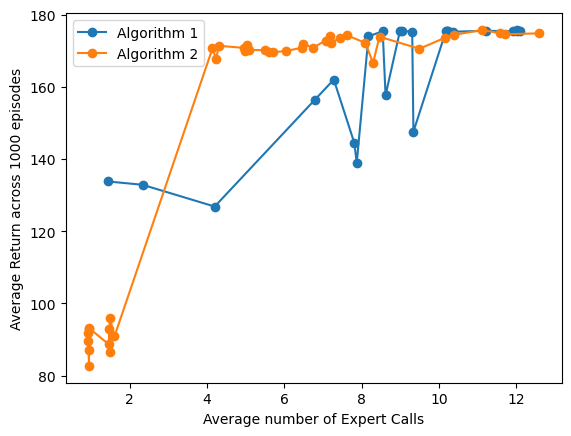

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizations
algo1_expert_calls = [10.233, 12.017, 9.0365, 11.2195, 12.1035, 8.5435, 10.2165, 10.3715, 10.1795, 8.9915, 8.6175, 12.017, 6.7805, 8.1755, 11.9275, 9.307, 7.278, 7.8085, 9.3385, 2.33, 4.196, 7.872, 1.436]
algo1_average_returns = [175.572, 175.631, 175.465, 175.499, 175.318, 175.354, 175.478, 175.25, 175.404, 175.522, 157.662, 175.4, 156.308, 173.972, 175.352, 175.251, 161.9805, 144.467, 147.564, 132.8485, 126.816, 138.892, 133.7615]
algo1_expert_penalties = [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9]
algo1_arr = np.array([algo1_expert_calls, algo1_average_returns, algo1_expert_penalties])
np.save('DQN_sparse_map/Plots/algo1_arr.npy', algo1_arr)
print(algo1_arr.shape)

sorted_inds = np.argsort(algo1_expert_calls)
algo1_expert_calls = np.array(algo1_expert_calls)[sorted_inds]
algo1_average_returns = np.array(algo1_average_returns)[sorted_inds]

algo2_expert_calls = [12.597, 11.72, 11.121, 11.577, 10.148, 10.392, 9.493, 8.294, 8.461, 8.093, 7.618, 7.451, 7.217, 7.182, 7.064, 6.739, 6.445, \
                      6.469, 6.053, 5.492, 5.698, 5.611, 5.026, 5.085, 4.982, 5.02, 4.955, 4.302, 4.234, 4.139, 1.604, 1.456, 1.475, 1.472, 1.48, 0.944, 0.93, 0.931, 0.95, 0.954, 0.934]
algo2_average_returns = [174.792, 174.546, 175.74, 174.828, 173.546, 174.374, 170.524, 166.616, 173.868, 172.144, 174.27, 173.584, 172.212, 174.146, 172.779, 170.824, 170.784, 171.927, 169.93, 170.155, 169.536, \
                         169.745, 171.521, 170.16, 169.878, 170.913, 170.757, 171.352, 167.698, 170.613, 90.885, 88.651, 86.502, 92.895, 96.03, 82.673, 89.652, 91.852, 92.983, 93.067, 87.172]
thresholds = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]

assert len(algo2_expert_calls) == len(algo2_average_returns) == len(thresholds)

algo2_arr = np.array([algo2_expert_calls, algo2_average_returns, thresholds])
print(algo2_arr.shape)
np.save('DQN_sparse_map/Plots/algo2_arr.npy', algo2_arr)

sorted_inds = np.argsort(algo2_expert_calls)
algo2_expert_calls = np.array(algo2_expert_calls)[sorted_inds]
algo2_average_returns = np.array(algo2_average_returns)[sorted_inds]

plt.plot(algo1_expert_calls, algo1_average_returns, label='Algorithm 1', marker='o', markersize=6)
plt.plot(algo2_expert_calls, algo2_average_returns, label='Algorithm 2', marker='o', markersize=6)
plt.xlabel('Average number of Expert Calls')
plt.ylabel('Average Return across 1000 episodes')
plt.legend()
plt.show()

Zhanpeng Plot

DQN Initialized
Number of Expert Calls that were allowed:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Average Expert Calls made across 2000 episodes:  [0.0, 0.9135, 1.778, 2.644, 3.4685, 4.3275, 5.171, 5.9, 6.4415, 6.733, 7.028, 7.098, 7.157, 7.171, 7.202]
Average Return:  [4.971, 46.7345, 71.3665, 105.3575, 119.9585, 132.0505, 145.0855, 152.601, 155.249, 155.109, 156.535, 156.641, 157.46, 155.517, 156.488]


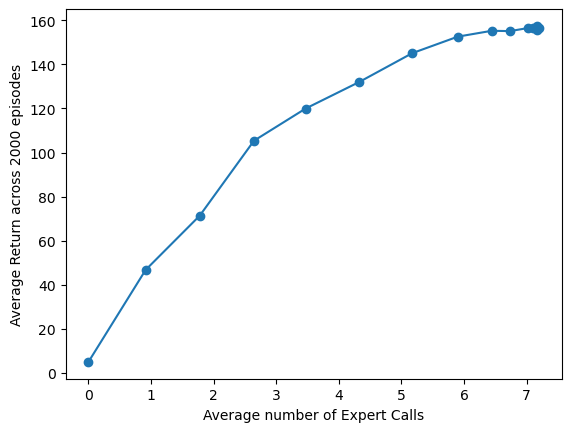

In [7]:
import os
import torch
from sparse_env import Grid
from dqn import DQN_Agent
import matplotlib.pyplot as plt
os.chdir('/home/sidd/Human-in-the-loop-RL/')


lr = 5e-5			# Learning rate for Q, M models
alg2 = False
logdir = 'DQN_sparse_map/Ocean/30k/v9/alg1'
expert_penalty = -0.9	# Value should be negative
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_num_threads(4)

# Adding all hyperparametres to a text file
os.makedirs(logdir, exist_ok=True)

env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
test_env = Grid(patch_size=5, expert_penalty=0, expert_map_f='DQN_sparse_map/Ocean/expert_policy.npy')
DQN = DQN_Agent(env, test_env, lr, device, burn_in=2)
expert_calls_list = []
avg_returns = []

for i in range(15):
    expert_calls, avg_return, _ = \
        DQN.zhanpeng_plot(2000, max_steps=25, max_expert_calls=i, qtable_f=f'DQN_sparse_map/Ocean/10k2/v2/Qvalues/Qvalues_550.npy')
    expert_calls_list.append(expert_calls)
    avg_returns.append(avg_return)

print('Number of Expert Calls that were allowed: ', [i for i in range(15)])
print('Average Expert Calls made across 2000 episodes: ', expert_calls_list)
print('Average Return: ', avg_returns)

# Plotting the results
plt.plot(expert_calls_list, avg_returns, label='Algorithm 1', marker='o', markersize=6)
plt.xlabel('Average number of Expert Calls')
plt.ylabel('Average Return across 2000 episodes')
plt.show()


ALG2 data files

/home/sidd/Human-in-the-loop-RL
(11, 16, 5)


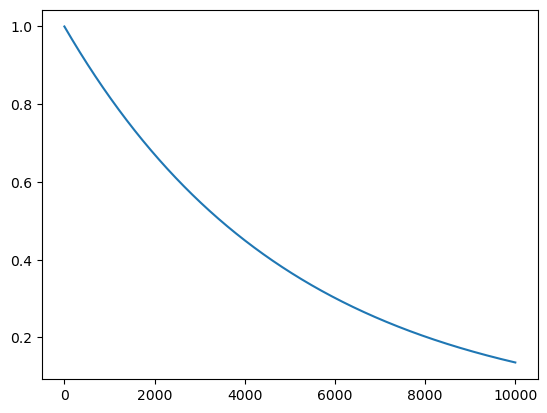

In [10]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
os.chdir('/home/sidd/Human-in-the-loop-RL/')


a = np.load('DQN_sparse_map/Ocean/10k2/v1/Qvalues/Qvalues_0.npy')
print(a.shape)


# for i in range(4200, 4600, 50):
#     qvals = torch.load('DQN_sparse_map/Ocean/10k2/v4/models/Qmodel_' + str(i) + '.pth')
#     episode = qvals['ep_number']
#     loss = qvals['loss']
#     print('Episode: ', episode)
#     print('Loss: ', loss)

# # Load qmodel from pytorch
# qvals = torch.load('DQN_sparse_map/Ocean/10k2/v4/models/Qmodel_4550.pth')
# episode = qvals['episode']
# loss = qvals['loss']

# print('Episode: ', episode)
# print('Loss: ', loss)

# qtable = np.load('Outputs/ALG2/10M.5/qtable.npy')
# print(qtable.shape)

# variances = qtable[:, :, :, 2]
# qvalues = qtable[:, :, :, 0]
# mvalues = qtable[:, :, :, 1]
# print(qvalues[2, 2])


# best_actions = np.argmax(qvalues, axis=2)
# # Plot best actions with actions as arrows
# sns.heatmap(best_actions, annot=True, fmt='d', cmap='viridis', cbar=False)
# plt.show()


# threshrollout = np.load('Outputs/ALG2/10M.5/thresh_rollout/thresholdrollout.npz')
# # expert_calls = threshrollout['expert_calls']
# # avg_returns = threshrollout['avg_returns']
# # print(expert_calls)
# # print(avg_returns)
# arr0 = threshrollout['arr_0']
# arr1 = threshrollout['arr_1']

# print(arr0.shape)
# print(arr1.shape)
import math
import numpy as np

decay_ep = 15000
num_episodes = 10000
eps_start = 1
eps_end = 0.05

if not decay_ep: decay_ep=num_episodes
lmda = math.log(eps_start/eps_end)/decay_ep

epsilon_list = []
for ep in range(num_episodes):
    epsilon = max(eps_start*math.exp(-lmda*ep), eps_end)
    epsilon_list.append(epsilon)

# Plot epsilon decay
import matplotlib.pyplot as plt
plt.plot(epsilon_list)
